In [1]:
%pip install streamlit
import numpy as np 
import pandas as pd
import os
import torch
import cv2
import streamlit as st
from collections import Counter
from PIL import Image
import re
import string
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer
from torchvision import models, transforms
import torchvision.transforms as T


from torchinfo import summary
from tqdm import tqdm 














   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 57.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


**Utility functions**

In [2]:
image_input_size=(224,224)
mean_normalization_vec=[0.485, 0.456, 0.406]
std_normalization_vec=[0.229, 0.224, 0.225]

image_transformation=T.Compose([T.Resize(image_input_size),T.ToTensor(),T.Normalize(mean=mean_normalization_vec,std=std_normalization_vec)])


def set_cuda():
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device in use : {}".format(device))
    return device

        

def Detensorize_image(image_tensor, mean_vector, std_vector, denormalize=True): 
    #reshape mean and std vectors to tensors with appropriate shape
    mean_tensor = torch.tensor(mean_vector).view(3, 1, 1)
    std_tensor = torch.tensor(std_vector).view(3, 1, 1)
    
    if denormalize:
        
        detensorized_image = (image_tensor * std_tensor) + mean_tensor
    else:
        detensorized_image = image_tensor
    
    
    detensorized_image = detensorized_image.permute(1, 2, 0)#convert image's dimensions from (C, H, W) to (H, W, C) 
    
    detensorized_image = detensorized_image.numpy()#convert the image tensor to a numpy array for visualization

    
    return detensorized_image




def standarize_text(text):
    text=text.strip()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '',text)#remove punctuation 
    text=text.lower()
   # text="<start> "+text+" <end>"
    return text



def plot_attention(img, caption, attention_vectors,is_streamlit=False):

    temp_image = img

    fig, axes = plt.subplots(len(caption) - 1, 1, figsize=(8, 8 * len(caption)))

    assert len(caption)>1,f" image has caption of {len(caption)}words only "

    for l, ax in enumerate(axes):
        temp_att = attention_vectors[l].reshape(7, 7)  # convert the 49 attention vector to 7x7 attention map
        
        
        att_resized = cv2.resize(temp_att, (temp_image.shape[1], temp_image.shape[0])) #resizingg attention map to match the image size


        ax.imshow(temp_image)
        ax.imshow(att_resized, cmap='jet', alpha=0.4)  # heat map over the original image for attended regions
        ax.set_title(caption[l])
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    if streamlit==True:
        st.pyplot(fig)#for compatibility with in streamlit's pyplot




def pick_random_image(directory):
 
    files = os.listdir(directory)
    

    images = [f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
    
    assert images, "no images  found in the directory."
    
    random_image = random.choice(images)
    
    return random_image





# DataSet


## dataset loading 

The dataset used in this project is the Flickr30k captioning data the images are stored seperately in an image folder and the captions are stored in a text file that contains the image-caption pairs


In [3]:
#------->For Flickr30k dataset usage...
datapath = "/kaggle/input/flickr30k-dataset" 
 

image_path = os.path.join(datapath, "Images")


captions_path = os.path.join(datapath, "captions.txt")#Captions format in text: "image name,image caption"


#------->For MS-COCO-2017 Dataset usage...
#datapath = "/kaggle/input/coco-2017-dataset/coco2017"
#image_path=os.path.join(datapath,"train2017")
#captions_path = os.path.join(datapath, "annotations/captions_train2017.json") #captions saved in 'annotation' json file


 **Extract the (image,captions) pairs from the caption.txt file using Regular expressions**  

In [4]:


image_names = []#saves image's name from "caption.txt" file
captions_list = []#saves image's caption' from "caption.txt" file
#tokens=[]


pattern = r'([a-zA-Z0-9]+\.jpg),\s*(.*)'# a regular expression pattern to match the image name and caption pairs in captions text file


with open(captions_path, 'r') as text:
    for line in text:
        match = re.match(pattern, line.strip())
        if match:
            img_name=match.group(1)
            img_caption=match.group(2)
            image_names.append(img_name)
            
            captions_list.append(standarize_text(img_caption))
            #tokens.append(preprocessed_text.split())

**storing (image name,caption) pairs in dataframe for easier processing and visualization**

In [6]:

im_cap_df=pd.DataFrame(
    {"Image_name":image_names,
    "caption":captions_list,
#"tokens":tokens
    }
)



## Exploring The captioning Dataset

In [7]:
im_cap_df.head(20)

Image_name                                            caption
0   1000092795.jpg  two young guys with shaggy hair look at their ...
1   1000092795.jpg   two young  white males are outside near many ...
2   1000092795.jpg    two men in green shirts are standing in a yard 
3   1000092795.jpg        a man in a blue shirt standing in a garden 
4   1000092795.jpg             two friends enjoy time spent together 
5     10002456.jpg  several men in hard hats are operating a giant...
6     10002456.jpg  workers look down from up above on a piece of ...
7     10002456.jpg    two men working on a machine wearing hard hats 
8     10002456.jpg               four men on top of a tall structure 
9     10002456.jpg                          three men on a large rig 
10  1000268201.jpg  a child in a pink dress is climbing up a set o...
11  1000268201.jpg  a little girl in a pink dress going into a woo...
12  1000268201.jpg  a little girl climbing the stairs to her playh...
13  1000268201.jpg     a little girl climbing into a wooden playhouse
14  1000268201.jpg               a girl going into a wooden building 
15  1000344755.jpg  someone in a blue shirt and hat is standing on...
16  1000344755.jpg  a man in a blue shirt is standing on a ladder ...
17  1000344755.jpg  a man on a ladder cleans the window of a tall ...
18  1000344755.jpg  man in blue shirt and jeans on ladder cleaning...
19  1000344755.jpg                  a man on a ladder cleans a window

In [8]:
im_cap_df.tail(20)

Image_name                                            caption
158895  997722733.jpg  a person in a red shirt climbing up a rock fac...
158896  997722733.jpg  a rock climber practices on a rock climbing wall 
158897  997722733.jpg           a man in a pink shirt climbs a rock face
158898  997722733.jpg            a man is rock climbing high in the air 
158899  997722733.jpg                     a rock climber in a red shirt 
158900  997876722.jpg  two male construction workers are working on a...
158901  997876722.jpg  two workmen with a wheelbarrow for mixing ceme...
158902  997876722.jpg  men in orange and yellow clothing lean over a ...
158903  997876722.jpg  men are working on pouring concrete outside of...
158904  997876722.jpg            fruits stationed by a dusty old window 
158905   99804383.jpg  an older busker in glasses plays an eastern st...
158906   99804383.jpg  this is a man in front of a store performing w...
158907   99804383.jpg  a older asian man is playing an instrument in ...
158908   99804383.jpg  an elderly man sits outside a storefront accom...
158909   99804383.jpg  an elderly gentleman playing a musical instrum...
158910  998845445.jpg   a man in shorts and a hawaiian shirt leans ov...
158911  998845445.jpg   a young man hanging over the side of a boat  ...
158912  998845445.jpg  a man is leaning off of the side of a blue and...
158913  998845445.jpg   a man riding a small boat in a harbor  with f...
158914  998845445.jpg  a man on a moored blue and white boat with hil...

**checking the consistency between the images in captions text file and image directory.**

In [9]:
print(f"total number of captions:{len(im_cap_df['caption'])}")
print(f"number of image entries in captions file:{im_cap_df['Image_name'].nunique()}")
print(f"number of images in images directory:{len([img for img in os.listdir(image_path) if os.path.isfile(os.path.join(image_path,img))])} ")
print(f"Caption count per image is: {im_cap_df.groupby('Image_name')['caption'].count().unique()}")


total number of captions:158915
number of image entries in captions file:31783
number of images in images directory:31783 
Caption count per image is: [5]


In [10]:


#making sure that all image files exist in the specified directory
missing_images = [name for name in image_names if not os.path.exists(os.path.join(image_path, name))]
assert not missing_images, f"cannot find image : {missing_images}in images directory"
print("All images entries in captions file matches images in images folder")


All images entries in captions file matches images in images folder


**displaying some Random images with their corresponding captions...**

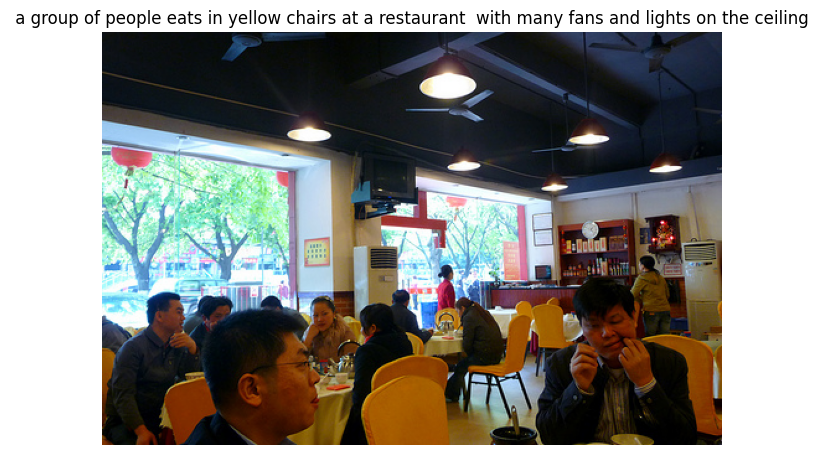

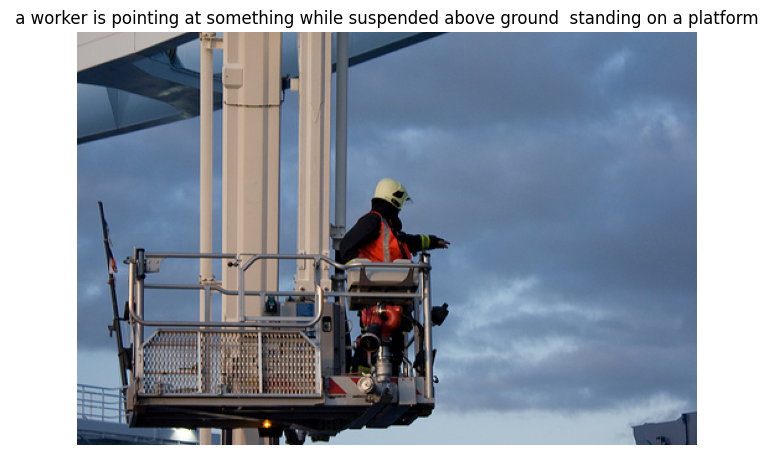

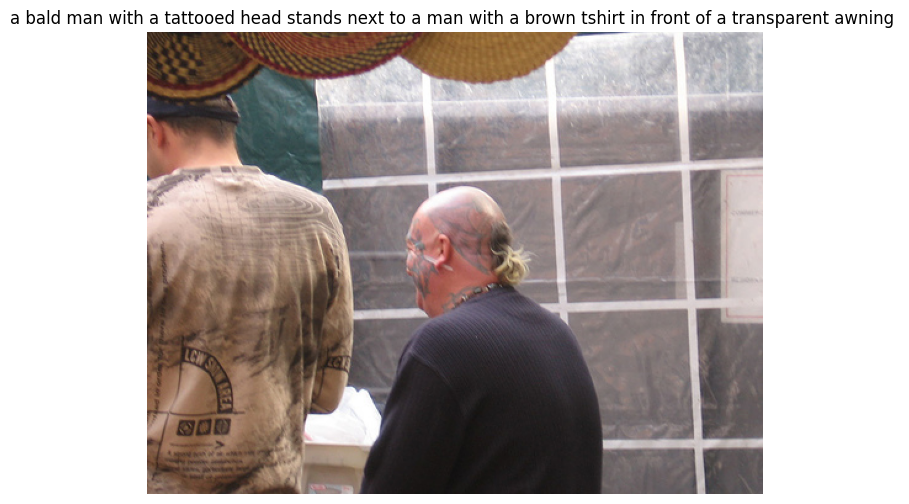

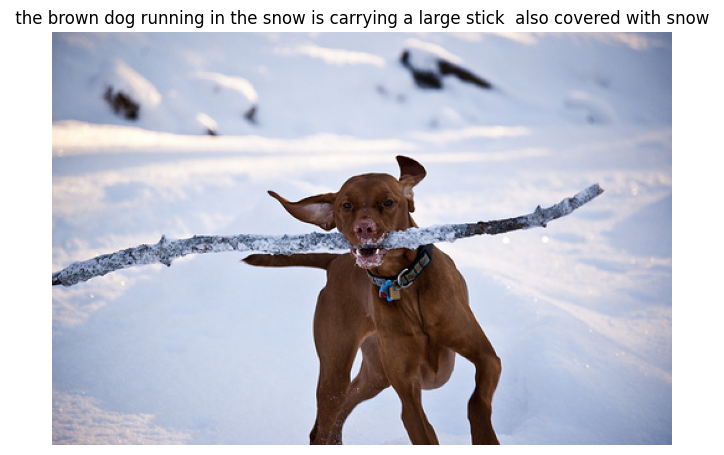

In [11]:

# display a random 4 images image and their corresponding caption
for i in range(4):
    image_name=pick_random_image(image_path)
    image_caption = im_cap_df[im_cap_df['Image_name'] == image_name]['caption'].iloc[0]
    
    img=Image.open(os.path.join(image_path,image_name+""))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')  
    plt.title(image_caption, fontsize=12)
    plt.show()



**Displaying top 100 frequent words**

Total number of tokens: 1948632
 number of unique tokens: 20009


Text(0, 0.5, 'word')

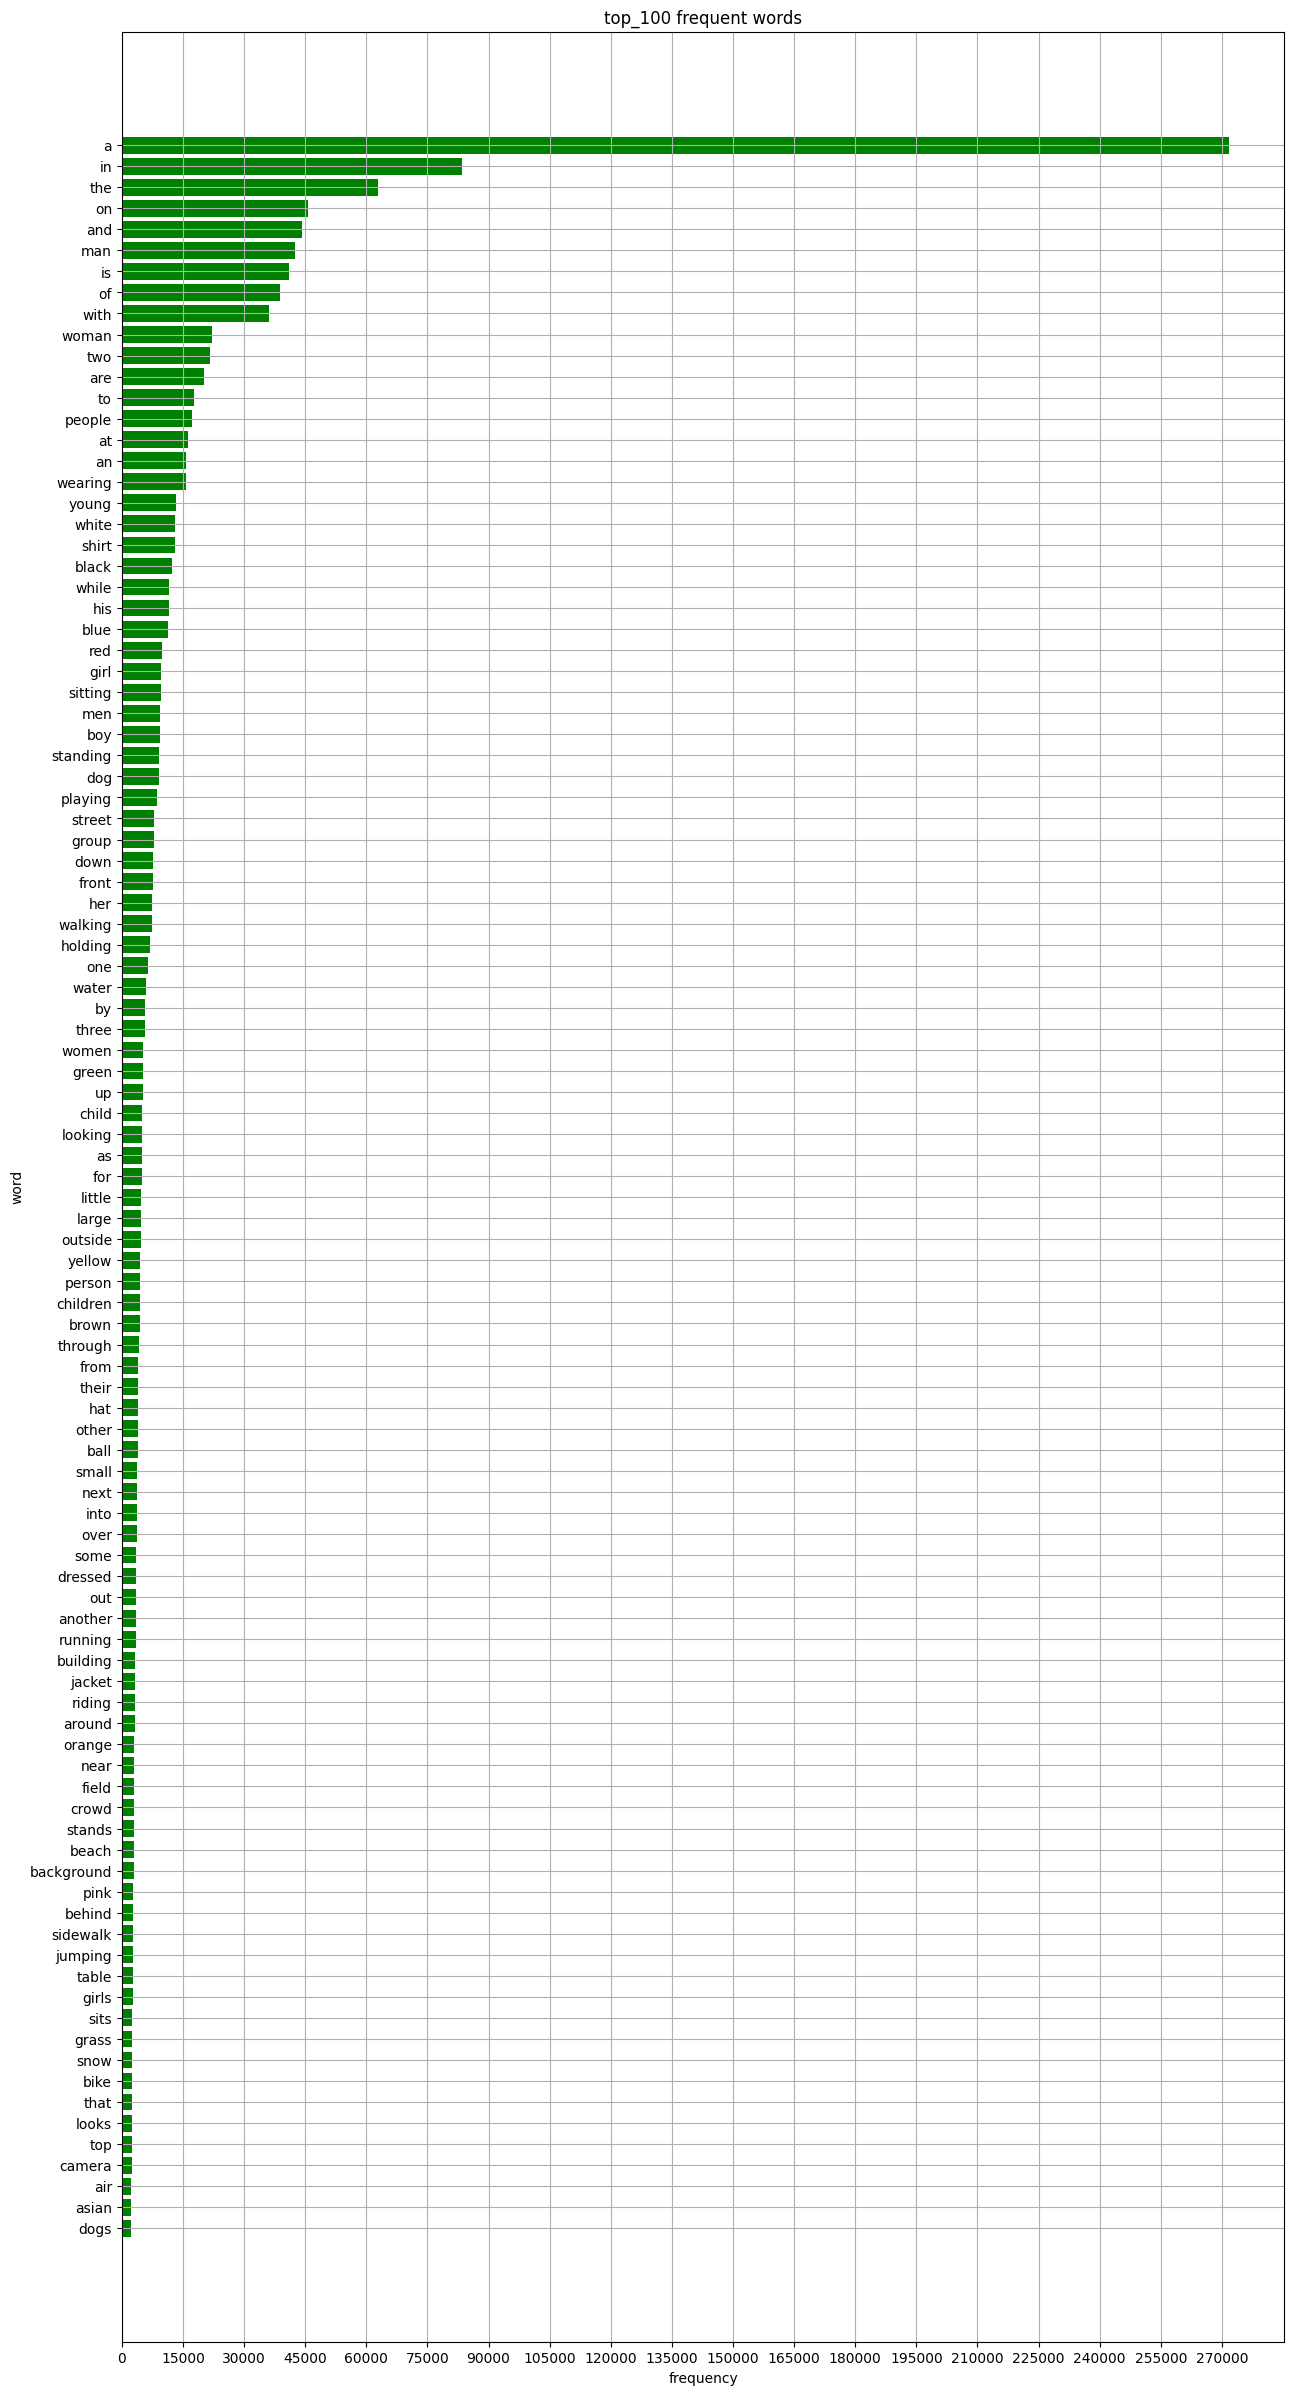

In [150]:

top_frequent=100

word_counts = Counter()


for caption in im_cap_df['caption']:
    caption=standarize_text(caption)
    caption_tokens = caption.split()  
    word_counts.update(caption_tokens) 

print("Total number of tokens:",sum(word_counts.values()))
print(" number of unique tokens:",len(word_counts))

most_common_words = word_counts.most_common(top_frequent)

words,frequencies=zip(*most_common_words)


plt.figure(figsize=(15,30))
plt.title(f"top_{top_frequent} frequent words")
plt.barh(words,frequencies, color='green')
plt.grid(True)
plt.xticks(range(0, max(frequencies),15000))
plt.gca().invert_yaxis()  # Optional: display most frequent words at the top

plt.xlabel('frequency')
plt.ylabel('word')


**Displaying least 100 frequent words**

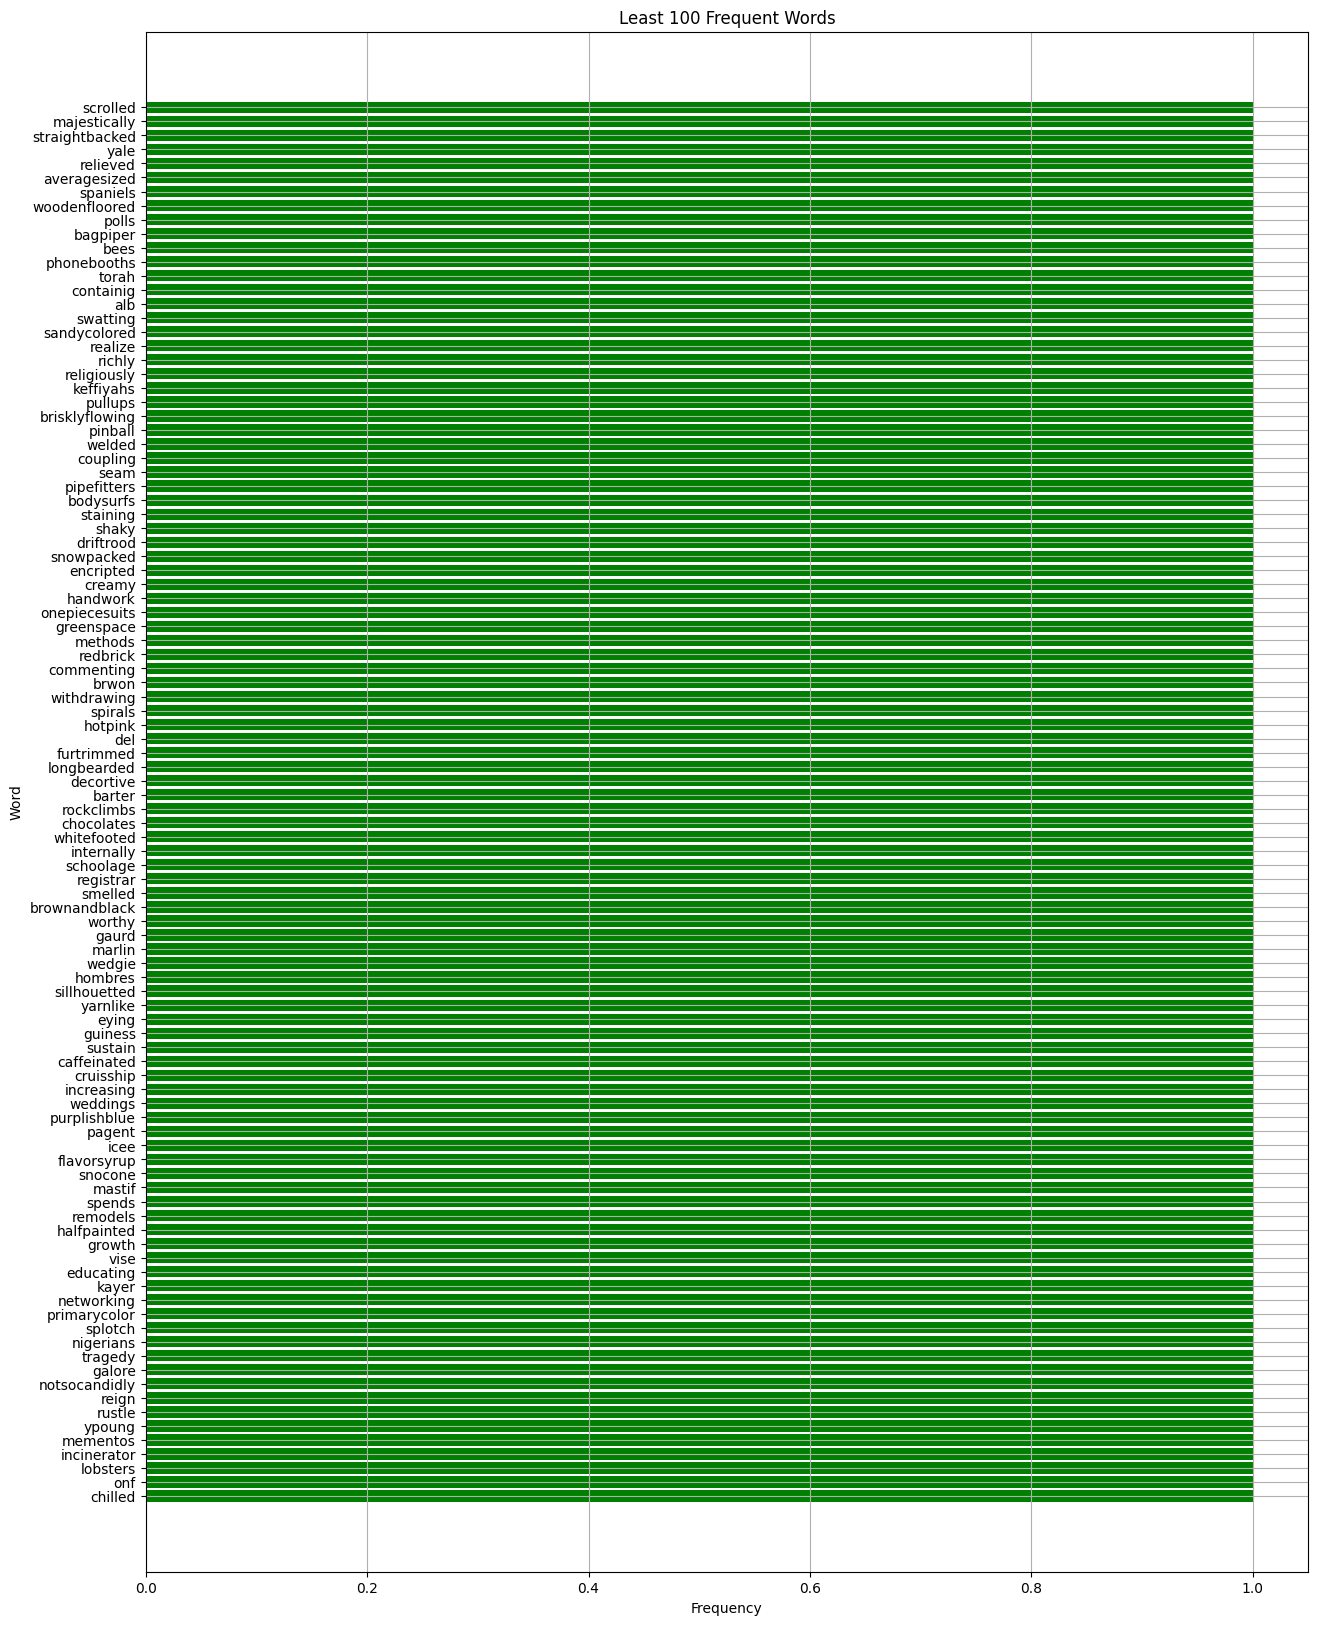

In [164]:
least_frequent = 100

# Get the least frequent words
least_common_words = word_counts.most_common()[-least_frequent:]

# Extract frequencies and words
words, frequencies = zip(*least_common_words)

# Plot the least frequent words
plt.figure(figsize=(15, 20))
plt.title(f"Least {least_frequent} Frequent Words")
plt.barh(words, frequencies, color='green')
plt.grid(True)

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()


**Calculating the frequencies Max,Min and average**

In [163]:
print("===========stats:===========")
print("Minimum Words Frequency:", min(frequencies))
print("Maximum Words Frequency:", max(frequencies))
print("Average Frequency:", sum(frequencies) / len(frequencies))


===========stats:===========
Minimum Words Frequency: 1
Maximum Words Frequency: 271704
Average Frequency: 97.38777550102454


# **The Vocabulary Class**

This class is used to build a vocabulary from a list of captions, where only words that appear more frequently than the specified threshold are included.

In [12]:
class Vocabulary:#creates vocab for tokens with freq>Fthreshold
    def __init__(self,caption_list,freq_threshold):
        self.caption_list=caption_list
        self.threshold=freq_threshold
        #adding special tokens
        self.idx2wrd={0:'<pad>',1:'<start>',2:'<end>',3:'<unknown>'}# used to map token ID to the actual token
        self.wrd2idx={word:idx for idx,word in self.idx2wrd.items()}#  maps token to its numerical ID
        self.create_vocab()
    
    def create_vocab(self):
        all_tokens = [word for caption in self.caption_list for word in caption.split()]
        
        
        word_counts = Counter(all_tokens)
        
        
        index = len(self.idx2wrd)  # start adding to the dict after the special tokens index
        for word, count in word_counts.items():
            if count >= self.threshold and word not in self.wrd2idx:
                self.wrd2idx[word] = index
                self.idx2wrd[index] = word
                index += 1
    
    def cap2tensor(self,caption):
        
        #numericalized_captions_list = []
        #for caption in self.caption_list:
            
        numericalized_caption = [self.wrd2idx['<start>']]# adding <start> token ID to the beginning of each caption in the list

            
        for word in caption.split():
            
            #numericalized_caption.append(self.wrd2idx.get(word, self.wrd2idx['<unknown>']))
 
            if word in self.wrd2idx:
                    numericalized_caption.append(self.wrd2idx[word])#if token found in vocab dict append its token ID 
            else:
                    numericalized_caption.append(self.wrd2idx['<unknown>'])#if token not found in vocab dict add <unknown> tag's ID

        numericalized_caption.append(self.wrd2idx['<end>'])# adding <end> token ID to  caption ending 
            
            #numericalized_captions_list.append(torch.tensor(numericalized_caption))#convert each numerical caption to a torch tensor
        
        return torch.tensor(numericalized_caption)
    
    def __len__(self):
        return len(self.wrd2idx)

# **Custom dataset class**

This class returns (preprocessed image,tokenized caption) tensors needed by the DataLoader. It loads images, applies transformations,and tokenizes captions using the provided vocabulary.

In [14]:
class Captioning_dataset(Dataset):
    def __init__(self,img_path,im_cap_df,vocab,img_transform=None):
        self.img_path=img_path
        self.im_cap_df=im_cap_df
        self.captions_list=im_cap_df['caption']
        self.img_names_list=im_cap_df['Image_name']
        self.vocab=vocab
        self.transformation=img_transform
        
        
    def __len__(self):
        return len(self.im_cap_df)

    def __getitem__(self,item_index):#for getting image,caption pairs as tensors
        image_name=self.img_names_list[item_index]
        caption=self.captions_list[item_index]
        img=cv2.imread(os.path.join(self.img_path,image_name))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=Image.fromarray(img)#Convert from Numpy array to PIL image object

        if self.transformation is not None:
            #Before Tensorization:Image object shape-->[Width,Height,Channels]
            
            img=self.transformation(img)
            
            #After Tensorization:Image shape-->[Channel,Widht,Height]        
        caption=self.vocab.cap2tensor(caption)
        return img,caption         #returns image,numericalized_caption  tensors



        
class Custom_collate_fn:
    def __init__(self,vocab,batch_first=True):
        self.vocab=vocab
        self.batch_first=batch_first
    def __call__(self,batch):
        
        images_batch = [item[0].unsqueeze(0) for item in batch]#creates a list of images tensors with shape (1,Channel,Width,Height)
        images_batch = torch.cat(images_batch,dim=0)#concatante the tensors inside the batch to become a single tensor with shape of (batch_size,Channel,Widht,Height)
        
        captions_batch = [item[1] for item in batch]
        captions_batch = pad_sequence(captions_batch, batch_first=self.batch_first, padding_value=self.vocab.wrd2idx['<pad>'])#pads the tensors within the batch with the padding index of <pad> tag to unify tensors size
        return images_batch,captions_batch  #returns:image tensor of shape:(bath_size,Channels,img_width,img_size),captions tensor of shape:(batch_size,max_caption_length) 
        

**Visualizing How the (image,caption) pairs will be passed to the model**

Loading 31783 batches, each of size: 5
----------------- sample -----------------
Decoded caption:
 <start> a group of women pose for a picture as a man plays guitar behind them <end>
Caption tensor: 
tensor([  1,  31, 264,  54, 257, 599, 426,  31, 973, 328,  31,  32, 279, 113,
        215, 216,   2])


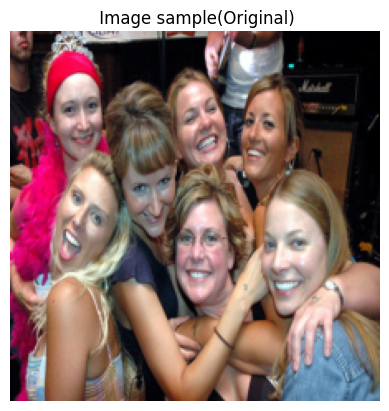

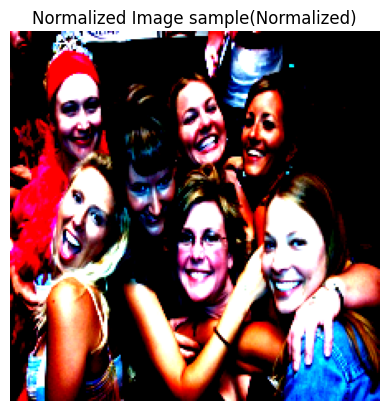

In [15]:
batchsize = 5  # Batch size > 1 to visualize padding in action
voc = Vocabulary(im_cap_df['caption'], 10)
dataset = Captioning_dataset(image_path, im_cap_df, voc, image_transformation)
train_dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True, collate_fn=Custom_collate_fn(voc))

# Loading batches information
print(f"Loading {len(train_dataloader)} batches, each of size: {batchsize}")
print("----------------- sample -----------------")

# Access the first batch
batch = next(iter(train_dataloader))
images_tensor, captions_tensor = batch

# Access the first image and caption in the batch
first_image = images_tensor[0]
first_caption_tensor = captions_tensor[0]

# Decode the caption
decoded_caption = " ".join([voc.idx2wrd[idx.item()] for idx in first_caption_tensor])

# Print decoded caption and its tensorized version
print(f"Decoded caption:\n {decoded_caption}")
print(f"Caption tensor: \n{first_caption_tensor}")

first_image_normalized = Detensorize_image(first_image, mean_normalization_vec, std_normalization_vec,denormalize=False)
first_image_denormalized = Detensorize_image(first_image, mean_normalization_vec, std_normalization_vec,denormalize=True)


plt.title(" Image sample(Original)")
plt.imshow(first_image_denormalized)
plt.axis("off")
plt.show()
#-------------------------------------------------------------------------
plt.title(" Image sample(Normalized)")
plt.imshow(first_image_normalized)
plt.axis("off")
plt.show()




# **Model Architecture**

## **Resnet101 Image Encoder**

Using pre-trained Resnet101 while excluding the last 2 layers (the fully connected layer and classification layer) as these layers are only used in classification problems, only the previous layers are needed for the image's features extraction which will be needed later by the attention layer.

In [16]:
class Image_encoder(nn.Module):
    def __init__(self):
        super(Image_encoder,self).__init__()
        self.resnet=models.resnet101(pretrained=True)# Resnet50 for features extraction
        for param in self.resnet.parameters():
            param.requires_grad_(False) 
        self.layers_list=list(self.resnet.children())[:-2]#remove last classification layer and it's fcl
        self.Resnet=nn.Sequential(*self.layers_list)

    
    def forward(self,image_tensor):
        features=self.Resnet(image_tensor) #----> shape:(images per batch , num of features , feature_filter_wdith , feature_filter_height)
                                     #(batch_size,2048,7,7)
        
        features=features.permute(0,2,3,1)#---> shape:(images per batch,feature width,feature height,num of features)
                                          #(batch_size,7,7,2048)
        
        features = features.view(features.size(0), -1, features.size(-1))#--->falttening features filter to a single tensor
        
        return features#--->shape:(images per batch,feature tensor,number of features per image)
                       #(batch_size,49,2048)

        
    
    

summary for the CNN layers included
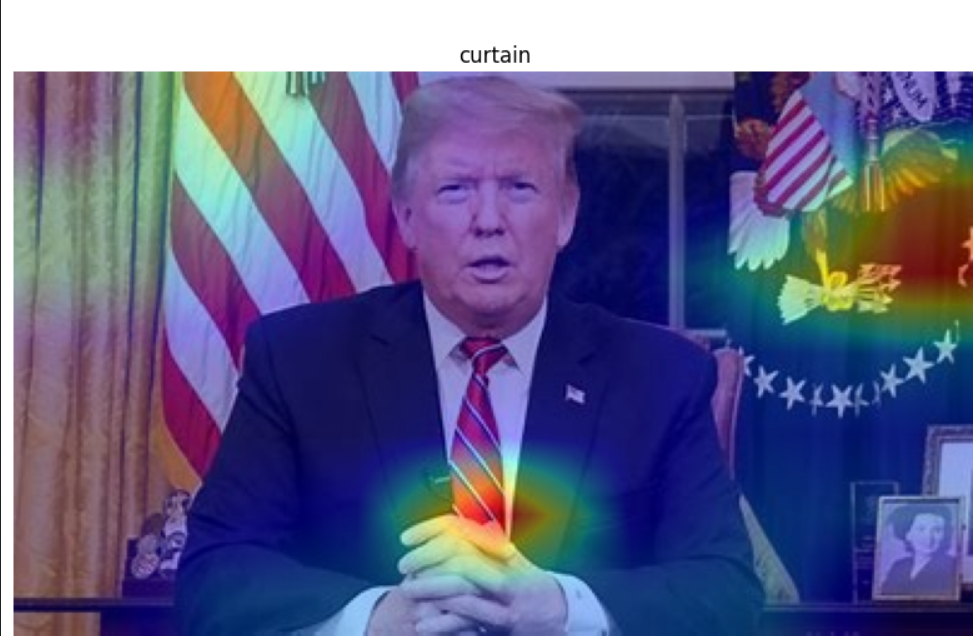

In [17]:


encoder=Image_encoder()
summary(encoder)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 217MB/s]  


Layer (type:depth-idx)                        Param #
Image_encoder                                 --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (1,512,448)
│    │    └─Bottleneck: 3-9                   (1,1

## **Attention Layer**

This implementation of the AttentionLayer utilizes the Bahdanau soft Attention mechanism. which  computes a context vector for each word in the caption by attending to specific parts of the image based on the hidden state of the previous timestamp. This enables the model to focus on relevant image regions while generating the next word in the sequence.

In [18]:

class AttentionLayer(nn.Module): #soft attention
    def __init__(self, features_dims, hidden_state_dims, attention_dims):
        super().__init__()

        self.attention_dims = attention_dims

        self.U = nn.Linear(features_dims, attention_dims)
        self.W = nn.Linear(hidden_state_dims, attention_dims)
        
        self.A = nn.Linear(attention_dims, 1) # compute attention scores using attention dims for both U & W


    def forward(self, img_features, hidden_state):

     #   print(img_features.shape)
        u_hs = self.U(img_features)  # input:(batch_size,img_feature_tensor_size,num_features per img)--->output:(batch_size,img_feature_tensor_size,attention_dims)
                                     #      :(batch_size,49,2048)------------------------->output:(batch_size,49,attention_dims)       
      
        
        w_hs = self.W(hidden_state)  # input:(batch_size,hidden_dim)->output:(batch_size,attention_dims)
        #w_hs=w_hs.unsqueeze(1)
        combined_states = torch.tanh(u_hs + w_hs.unsqueeze(1))  # outputs:(batch_size, feature_tensor_size, attention_dims)

        
        attention_scores = self.A(combined_states)  # (batch_size, feature_tensor, 1)

        
        attention_scores = attention_scores.squeeze(2)  # from (batch_size,feature_tensor_size,1) to-->(batch_size,feature_tensor_size)

        
        alpha = F.softmax(attention_scores, dim=1)  
       
        
        #print("alpha shape in attention fwd:",alpha.shape)
        
        
        context_vector = img_features * alpha.unsqueeze(2)  # (batch_size, num_pixels, features_dims)
        
        context_vector = context_vector.sum(dim=1)  # (batch_size, features_dims)
                                                    # Weigthed image features vector 

        return alpha, context_vector  # alpha for visualization, context_vector for RNN feeding


## **The LSTM decoder**

 a single LSTM network layer that uses both the current token and context vector that created by the previous attention layer to predict the next token in the sequence,the intial hidden layer at timestep 0 will be intialized by the normalized image's features vector

In [19]:
class Attention_Based_Decoder(nn.Module):
    def __init__(self,features_dims,hidden_state_dims,attention_dims,word_emb_dims,vocab_size,drop_prob):
        super().__init__()


        
        self.vocab_size=vocab_size

        
        self.dropout_layer=nn.Dropout(drop_prob)
        self.attention_layer=AttentionLayer(features_dims,hidden_state_dims,attention_dims)
        self.tokens_embedding=nn.Embedding(vocab_size,word_emb_dims)
        
        self.hidden_state_init=nn.Linear(features_dims,hidden_state_dims)#fcl to intialize hidden_state
        self.cell_state_init=nn.Linear(features_dims,hidden_state_dims)##fcl to intialize cell_state

        self.lstm_cell = nn.LSTMCell(word_emb_dims+features_dims,hidden_state_dims,bias=True)
        self.fcl=nn.Linear(hidden_state_dims,vocab_size)
    

    def init_hidden_state(self,image_features_tensor):
        features_mean=image_features_tensor.mean(dim=1)
        h=self.hidden_state_init(features_mean)
        c=self.cell_state_init(features_mean)
        return h,c


    
    
    def forward(self,batch_images_features,batch_captions_tensors):# takes a batch of image features tensors and a batch of numericalized caption tensor

        #image features shape:(batch_size,49,2048)
        #captions tensors shape:(batch_size,max_length)



        
        captions_len=len(batch_captions_tensors[0])-1 #length of the first caption in the batch=max_length
        batch_size=batch_captions_tensors.size(0)   #number of captions within each batch
        
        features_size=batch_images_features.size(1) #size of feature vector 
        embedded_tokens=self.tokens_embedding(batch_captions_tensors)#maps each token IDs to it's embedding  
        hidden_state,cell_state=self.init_hidden_state(batch_images_features)#initialize hidden & cell states with the mean of img features tensor
        
    
        
        preds = torch.zeros(batch_size, captions_len,self.vocab_size).to(device) #(num of captions,num of tokens in caption,possible_tokens)
        alphas = torch.zeros(batch_size, captions_len,features_size).to(device)     #(num of captions,num of tokens in captions,features_per_token)
                
        
        for wrd_index in range(captions_len):
            alpha,context_vector=self.attention_layer(batch_images_features,hidden_state)
            
            current_token_emb=embedded_tokens[:,wrd_index]# using teacher force by feeding the ground truth value of current time stamp  as an input for time t+1
            
            lstm_input=torch.cat((current_token_emb,context_vector),dim=1)
            
            hidden_state,cell_state=self.lstm_cell(lstm_input,(hidden_state,cell_state))
            
            tokens_probs=self.fcl(self.dropout_layer(hidden_state))
            
            preds[:,wrd_index] = tokens_probs #next token probabilities after current token
            
            alphas[:,wrd_index] = alpha #alpha factor for current token
            
        #print("alpha shape in decoder fwd:",alpha.shape)

  
        return preds,alphas


**The Encoder-Decoder Model**(putting everything together)

*The final captioning model will be consisting of:*

* **The Encoder** extracts images features into and pass them to the attention layer

* **Attention layer** combines both the extracted features from the encoder with the  hidden state that created by the RNN in the previous time step to create a context vector
  
* **The LSTM Component** uses the context vector created by the attention mechanism along with the previous hidden state to predict the next token


In [20]:
class Encoder_Decoder_Model(nn.Module):
    def __init__(self,features_dims,hidden_state_dims,attention_dims,word_emb_dims,vocab_size,drop_prob):
        super().__init__()
        self.img_encoder=Image_encoder()
        self.decoder=Attention_Based_Decoder(features_dims,hidden_state_dims,attention_dims,word_emb_dims,vocab_size,drop_prob)


    def forward(self,batch_images,batch_tokenized_captions):
        
        image_features=self.img_encoder(batch_images)
        probs,alphas=self.decoder(image_features,batch_tokenized_captions)
        #print("encoder_decoder final alphaoutput:",alphas.shape)
        return probs,alphas
 
    
    def predict(self,image,vocab,max_cap_len=20,debugging=False):
        
        self.eval()
        with torch.no_grad():
            img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            img=Image.fromarray(img)
            
            
            img = image_transformation(img).unsqueeze(0).to(device)
    
            image_features=self.img_encoder(img)
            
            if debugging:
                print(f"predict input image_Shape:{image_features.shape}\n")# for debugging only!!

            
            hidden_state,cell_state=self.decoder.init_hidden_state(image_features)
            
            caption=[vocab.idx2wrd[1]]
            
            token=torch.tensor(vocab.wrd2idx["<start>"]).unsqueeze(0).to(device)
           
            
            attentions=[]
            
            for i in range(max_cap_len):
                 
                alpha,context_vector=self.decoder.attention_layer(image_features,hidden_state)
                
                if debugging:
                
                    print(i,"-attention map for token:",vocab.idx2wrd[token.item()],"is",alpha.shape) # for debugging only!!
                
    
                attentions.append(alpha.cpu().detach().numpy())
    
                current_token_emb=self.decoder.tokens_embedding(token)
                
                lstm_input=torch.cat((current_token_emb.squeeze(1),context_vector),dim=1)
                
                hidden_state,cell_state=self.decoder.lstm_cell(lstm_input,(hidden_state,cell_state))
                
                tokens_prob=self.decoder.fcl(hidden_state)
                
                next_token=tokens_prob.argmax(dim=1).item()
                
                next_word=vocab.idx2wrd[next_token]
                
                caption.append(next_word)
                
                if next_word=="<end>":
                    
                    break
                token=torch.tensor([next_token]).unsqueeze(0).to(device)
                
            if debugging:
                print("attention shape:",np.array(attentions).shape)
                print("caption_length:",len(caption))# for debugging only!!
            return attentions,caption
    
            

# **Training**

## **training Hyper-parameters**

In [21]:
device=set_cuda()

LEARNING_RATE = 1e-4


WORD_EMB_SIZE = 400
ATTENTION_DIMS=512  # 2048 pixels/512 attention vector = 16 --->each attention score is attending to 8 pixels in features map
HIDDEN_STATE_DIMS=1024

NUM_EPOCHS = 10
BATCH_SIZE=128

vocab=Vocabulary(im_cap_df['caption'],5)#set min threshold to 5 occurances
VOCAB_SIZE=len(vocab)

model=Encoder_Decoder_Model(features_dims=2048,hidden_state_dims=HIDDEN_STATE_DIMS,attention_dims=ATTENTION_DIMS,word_emb_dims=WORD_EMB_SIZE,vocab_size=VOCAB_SIZE,drop_prob=0.5)

Device in use : cuda


## **Dataset Splitting**

since each image in the dataset has 5 captions, it is necessary to ensure that images in the training dataset do not appear again in the validation dataset,so the traditional random_split method is unsuitable for this scenario,an image-based splitting approach is used instead. This prevents data leakage and ensures that the model is evaluated on unseen images

In [22]:
unique_imgs_names =list(im_cap_df['Image_name'].unique())


train_imgs, val_imgs = torch.utils.data.random_split(unique_imgs_names, [0.9, 0.1])
train_imgs = [unique_imgs_names[idx] for idx in train_imgs.indices]
val_imgs = [unique_imgs_names[idx] for idx in val_imgs.indices]



train_df = im_cap_df[im_cap_df['Image_name'].isin(train_imgs)].reset_index(drop=True)
val_df = im_cap_df[im_cap_df['Image_name'].isin(val_imgs)].reset_index(drop=True)
train_dataset=Captioning_dataset(image_path,train_df,vocab,image_transformation)
val_dataset=Captioning_dataset(image_path,val_df,vocab,image_transformation)


train_dataloader=DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True,collate_fn=Custom_collate_fn(vocab))
val_dataloader=DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True,collate_fn=Custom_collate_fn(vocab))

## **Training Loop**

In [23]:
model=model.to(device)
CRITERION = nn.CrossEntropyLoss(ignore_index=dataset.vocab.wrd2idx["<pad>"]).to(device)  # Ignore loss for padding tokens
OPTIMIZER = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print_every = 500 # batches progress are displayed according to this number 

training_losses = []
validation_losses=[]
best_loss = float('inf')  # Initialize best loss to +infinity

for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Epochs"):
    print(f"Epoch: {epoch}/{NUM_EPOCHS}")
    train_losses_sum = 0
    model.train()

    
    for batch, (images_batch, captions_batch) in enumerate(train_dataloader, start=1):
        
        images_batch, captions_batch = images_batch.to(device), captions_batch.to(device)# move batches to the GPU
        
        OPTIMIZER.zero_grad()
        
        
        output, _ = model(images_batch, captions_batch)#fwd pass
        
        
        ground_truth = captions_batch[:, 1:]#exclude <start> tag as it won't be predicted by the model
        
        loss = CRITERION(output.view(-1, VOCAB_SIZE), ground_truth.reshape(-1))
        
        loss.backward()
        
        OPTIMIZER.step()
        
        train_losses_sum += loss.item()

        if loss < best_loss:# save model if loss improved
            best_loss = loss
            print(f"Model loss improved to: {loss.item()}, saving...")
            torch.save(model.state_dict(), "trained_captioning_model.pt")
        
        if batch % print_every == 0:
            print(f"Batch: {batch}/{len(train_dataloader)}") #print batch number every (print_every)th batch

    train_avg_loss = train_losses_sum / len(train_dataloader) #avg loss within the epoch 
    training_losses.append(train_avg_loss)# for plotting losses later
    print(f" Validating....")
    model.eval()
    val_losses_sum = 0
    with torch.no_grad():
        for images_batch,captions_batch in val_dataloader:
            images_batch,captions_batch=images_batch.to(device),captions_batch.to(device)
            output, _ = model(images_batch, captions_batch)
            
            ground_truth = captions_batch[:, 1:]  
            val_loss = CRITERION(output.view(-1, VOCAB_SIZE), ground_truth.reshape(-1))
            
            val_losses_sum += val_loss.item()
    
    val_avg_loss = val_losses_sum / len(val_dataloader)
    validation_losses.append(val_avg_loss)
    print(f"Epoch {epoch} Average Training loss: {train_avg_loss}-Average Validation loss: {val_avg_loss}")
    



Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Model loss improved to: 8.955662727355957, saving...
Model loss improved to: 8.80219841003418, saving...
Model loss improved to: 8.633733749389648, saving...
Model loss improved to: 8.459403038024902, saving...
Model loss improved to: 8.269135475158691, saving...
Model loss improved to: 8.022862434387207, saving...
Model loss improved to: 7.856915473937988, saving...
Model loss improved to: 7.657598495483398, saving...
Model loss improved to: 7.529716968536377, saving...
Model loss improved to: 7.278317928314209, saving...
Model loss improved to: 7.168412685394287, saving...
Model loss improved to: 7.02962064743042, saving...
Model loss improved to: 6.901544094085693, saving...
Model loss improved to: 6.861182689666748, saving...
Model loss improved to: 6.707836627960205, saving...
Model loss improved to: 6.562291145324707, saving...
Model loss improved to: 6.534711837768555, saving...
Model loss improved to: 6.4444475173950195, saving...
Model loss improved to: 6.243091583

Epochs:  10%|█         | 1/10 [15:52<2:22:49, 952.19s/it]

Epoch 1 Average Training loss: 4.459655307060064-Average Validation loss: 3.83965390586853
Epoch: 2/10
Model loss improved to: 3.6296510696411133, saving...
Model loss improved to: 3.6167333126068115, saving...
Model loss improved to: 3.579113245010376, saving...
Model loss improved to: 3.564547300338745, saving...
Model loss improved to: 3.526488780975342, saving...
Batch: 500/1118
Model loss improved to: 3.51361083984375, saving...
Model loss improved to: 3.5054690837860107, saving...
Model loss improved to: 3.450644016265869, saving...
Model loss improved to: 3.412144660949707, saving...
Batch: 1000/1118
Model loss improved to: 3.3975720405578613, saving...
Model loss improved to: 3.375216007232666, saving...
 Validating....


Epochs:  20%|██        | 2/10 [30:33<2:01:24, 910.53s/it]

Epoch 2 Average Training loss: 3.718415451817521-Average Validation loss: 3.517192440032959
Epoch: 3/10
Model loss improved to: 3.373828411102295, saving...
Model loss improved to: 3.3330719470977783, saving...
Model loss improved to: 3.3169898986816406, saving...
Model loss improved to: 3.288447141647339, saving...
Model loss improved to: 3.2494800090789795, saving...
Batch: 500/1118
Model loss improved to: 3.186908483505249, saving...
Model loss improved to: 3.1557624340057373, saving...
Batch: 1000/1118
Model loss improved to: 3.0992703437805176, saving...
 Validating....


Epochs:  30%|███       | 3/10 [45:11<1:44:30, 895.79s/it]

Epoch 3 Average Training loss: 3.4691347787973066-Average Validation loss: 3.3591692295074465
Epoch: 4/10
Batch: 500/1118
Model loss improved to: 3.0297327041625977, saving...
Model loss improved to: 3.022702932357788, saving...
Batch: 1000/1118
 Validating....


Epochs:  40%|████      | 4/10 [59:50<1:28:54, 889.16s/it]

Epoch 4 Average Training loss: 3.31336812341789-Average Validation loss: 3.2477707958221433
Epoch: 5/10
Model loss improved to: 3.000326633453369, saving...
Batch: 500/1118
Model loss improved to: 2.98227596282959, saving...
Model loss improved to: 2.949749708175659, saving...
Model loss improved to: 2.935943126678467, saving...
Batch: 1000/1118
 Validating....


Epochs:  50%|█████     | 5/10 [1:14:27<1:13:43, 884.62s/it]

Epoch 5 Average Training loss: 3.2006427985824284-Average Validation loss: 3.1772868309020996
Epoch: 6/10
Model loss improved to: 2.901139736175537, saving...
Batch: 500/1118
Model loss improved to: 2.897897481918335, saving...
Model loss improved to: 2.8657147884368896, saving...
Model loss improved to: 2.820072889328003, saving...
Batch: 1000/1118
 Validating....


Epochs:  60%|██████    | 6/10 [1:29:05<58:49, 882.38s/it]  

Epoch 6 Average Training loss: 3.1098681054942725-Average Validation loss: 3.1286282920837403
Epoch: 7/10
Model loss improved to: 2.8146748542785645, saving...
Batch: 500/1118
Model loss improved to: 2.802934169769287, saving...
Batch: 1000/1118
Model loss improved to: 2.7769522666931152, saving...
 Validating....


Epochs:  70%|███████   | 7/10 [1:43:40<44:00, 880.15s/it]

Epoch 7 Average Training loss: 3.034877536974994-Average Validation loss: 3.088386545181274
Epoch: 8/10
Model loss improved to: 2.776149034500122, saving...
Model loss improved to: 2.769305467605591, saving...
Batch: 500/1118
Model loss improved to: 2.761392831802368, saving...
Model loss improved to: 2.741798162460327, saving...
Model loss improved to: 2.624579668045044, saving...
Batch: 1000/1118
 Validating....


Epochs:  80%|████████  | 8/10 [1:58:18<29:18, 879.19s/it]

Epoch 8 Average Training loss: 2.9690077051067183-Average Validation loss: 3.055041608810425
Epoch: 9/10
Batch: 500/1118
Batch: 1000/1118
 Validating....


Epochs:  90%|█████████ | 9/10 [2:12:53<14:38, 878.11s/it]

Epoch 9 Average Training loss: 2.911276552459635-Average Validation loss: 3.0275193710327146
Epoch: 10/10
Model loss improved to: 2.609031915664673, saving...
Batch: 500/1118
Batch: 1000/1118
 Validating....


Epochs: 100%|██████████| 10/10 [2:27:30<00:00, 885.03s/it]

Epoch 10 Average Training loss: 2.8586622651446483-Average Validation loss: 3.009297775268555


## **Plotting Training & Validation Losses**

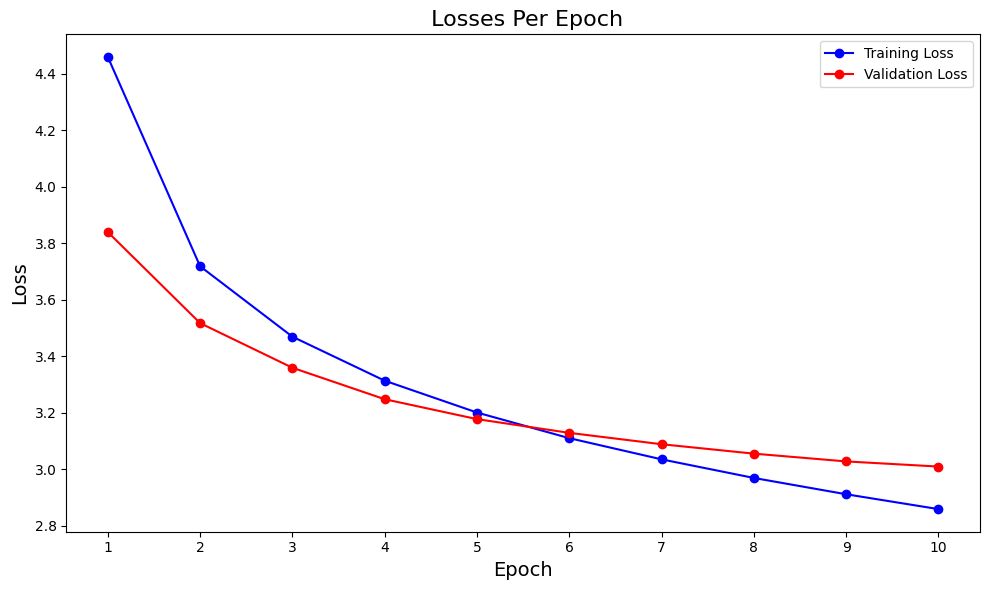

In [24]:
plt.figure(figsize=(10, 6))

#training loss curve
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o', color='b', label='Training Loss')

#validation loss curve
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', color='r', label='Validation Loss')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title(' Losses Per Epoch', fontsize=16)
plt.legend()
plt.xticks(range(1, len(training_losses) + 1))
plt.tight_layout()
plt.show()

## **Saving the model's weights and vocab for deployment stage**

In [25]:
torch.save(model,"flkr30modeltrained.pt")
#model=torch.load('/kaggle/working/captioning_model_mscocov3.pt')

In [26]:
torch.save(vocab,"flickr-vocab-f10.pth")

# **Inference**

## **Generating captions**

testing on random images uploaded by me...

predict input image_Shape:torch.Size([1, 49, 2048])

0 -attention map for token: <start> is torch.Size([1, 49])
1 -attention map for token: a is torch.Size([1, 49])
2 -attention map for token: young is torch.Size([1, 49])
3 -attention map for token: girl is torch.Size([1, 49])
4 -attention map for token: is is torch.Size([1, 49])
5 -attention map for token: holding is torch.Size([1, 49])
6 -attention map for token: a is torch.Size([1, 49])
7 -attention map for token: baby is torch.Size([1, 49])
attention shape: (8, 1, 49)
caption_length: 9
------------------Generated Caption:------------------
<start> a young girl is holding a baby <end>


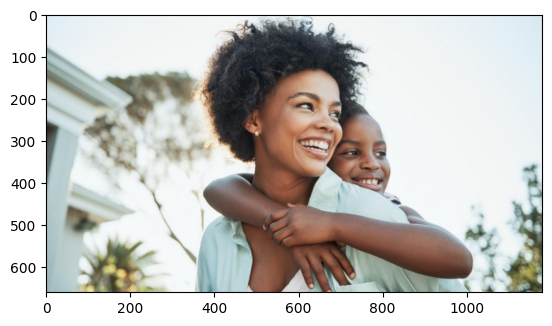

In [31]:
test_dir="/kaggle/input/custom-test-set"
#test_dir="/kaggle/input/flickr30k-dataset/Images"

random_image=pick_random_image(test_dir)
#test_image = cv2.imread('/kaggle/input/flickr30k-dataset/Images/1011572216.jpg')

test_image = cv2.imread(os.path.join(test_dir,random_image))
display_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)

alphas,caption=model.predict(test_image,vocab=vocab,debugging=True)
print("------------------Generated Caption:------------------")
decoded_caption=" ".join(caption)
print(" ".join(caption))
plt.imshow(display_image)


## **Visualizing attentions**

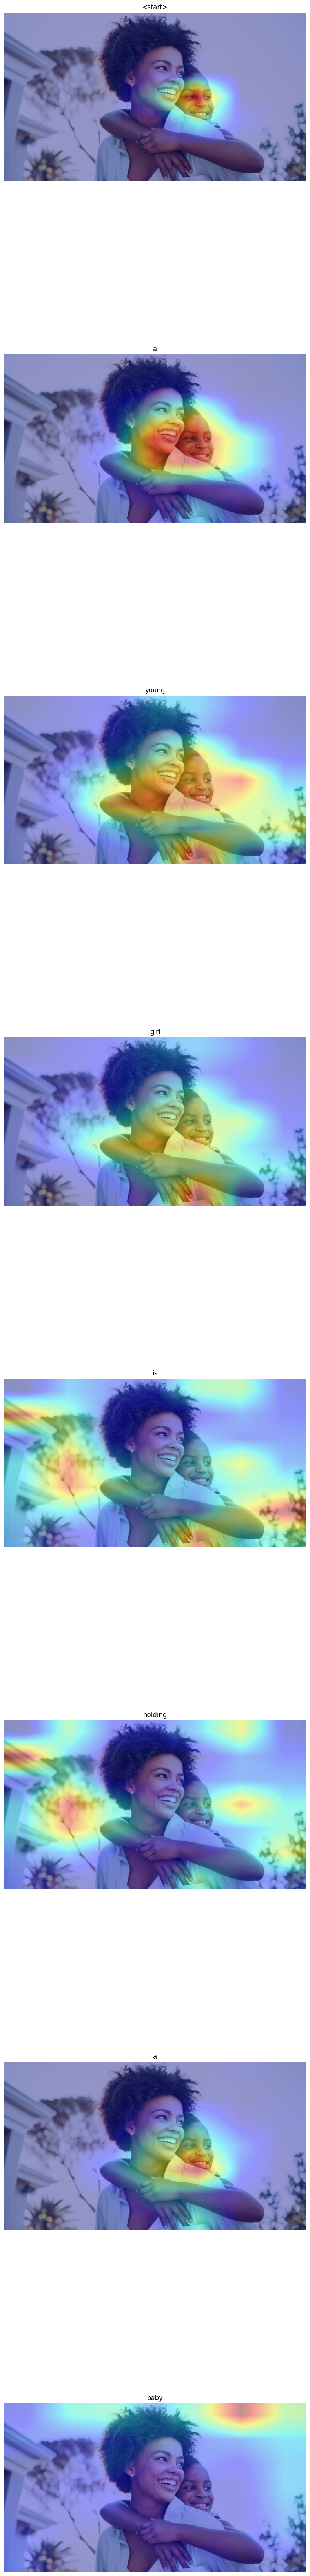

NameError: name 'streamlit' is not defined

In [32]:
plot_attention(display_image,caption,alphas)#show attentions region and their corresponding words


print("alphas length",len(alphas))
print("caption length",len(caption))
